# Data Processing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob, re, h5py
from utils.h5utils import load_h5_file, write_data_to_h5, aggregate_data_file
from utils.constants import *

from utils.date_util import generate_date_range

In [2]:
print(GET_CITIES)

['ANTWERP']


In [3]:
S_2019_DATE = '2019-04-01'
E_2019_DATE = '2019-05-30'
S_2020_DATE = '2020-04-01'
E_2020_DATE = '2020-05-30'

pre_covid_range = generate_date_range(S_2019_DATE, E_2019_DATE)
in_covid_range = generate_date_range(S_2020_DATE, E_2020_DATE)

# pre_covid_range,in_covid_range

In [4]:
date_range = generate_date_range(S_2019_DATE, E_2019_DATE)

In [5]:
from pathlib import Path
for date in date_range:
    filename = f"{BASE_FOLDER}/{CITY_ANTWERP}/training/{date}_{CITY_ANTWERP}_8ch"
    aggregate_data_file(filename)


(24, 495, 436, 8)


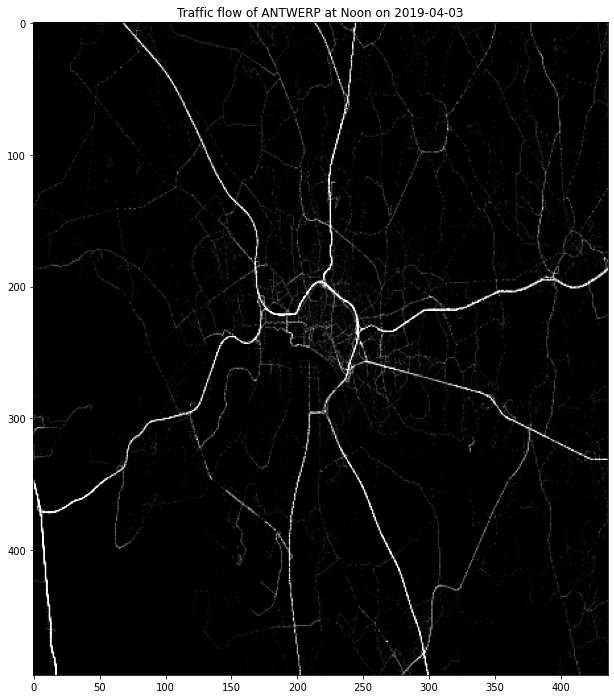

In [8]:
scale_factor = 12
test_date = '2019-04-03'

third_apr = load_h5_file(
    f"{BASE_FOLDER}/{CITY_ANTWERP}/training/{test_date}_{CITY_ANTWERP}_8ch_aggregated.h5")
print(third_apr.shape)
map_at_noon = third_apr[11].sum(axis=(-1))
plt.figure(figsize=(scale_factor, scale_factor))
plt.title(f'Traffic flow of {CITY_ANTWERP} at Noon on {test_date}')
plt.imshow(map_at_noon[0:495, 0:436], cmap="gray", vmin=0, vmax=255)


Loaded data has shape (24, 495, 436, 8) with dtype uint8 between 0 and 255
Reading pixel 349,0


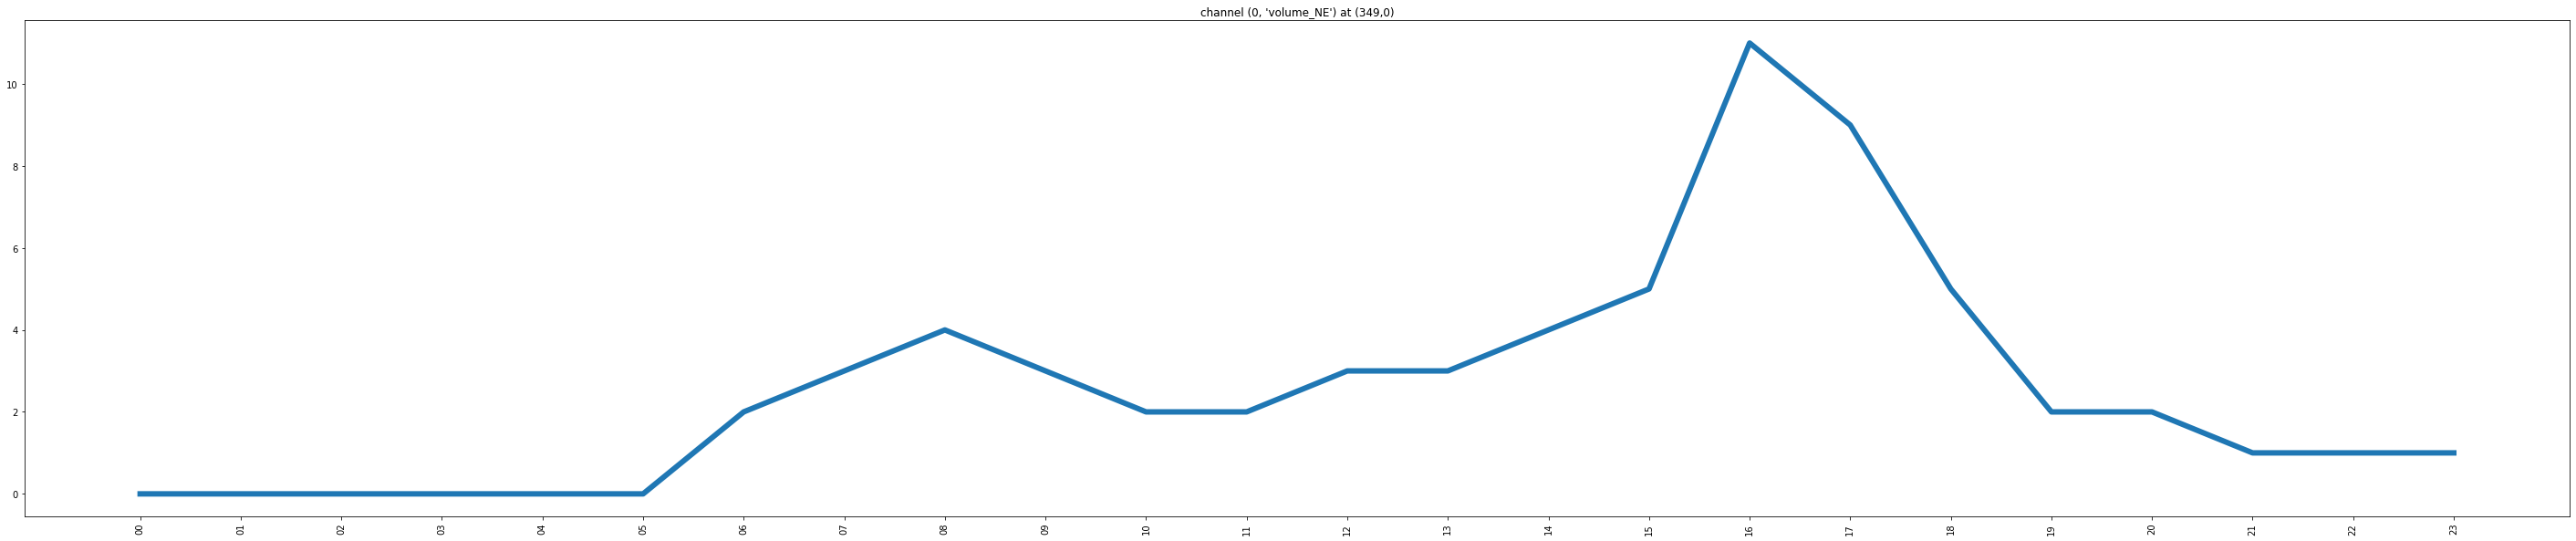

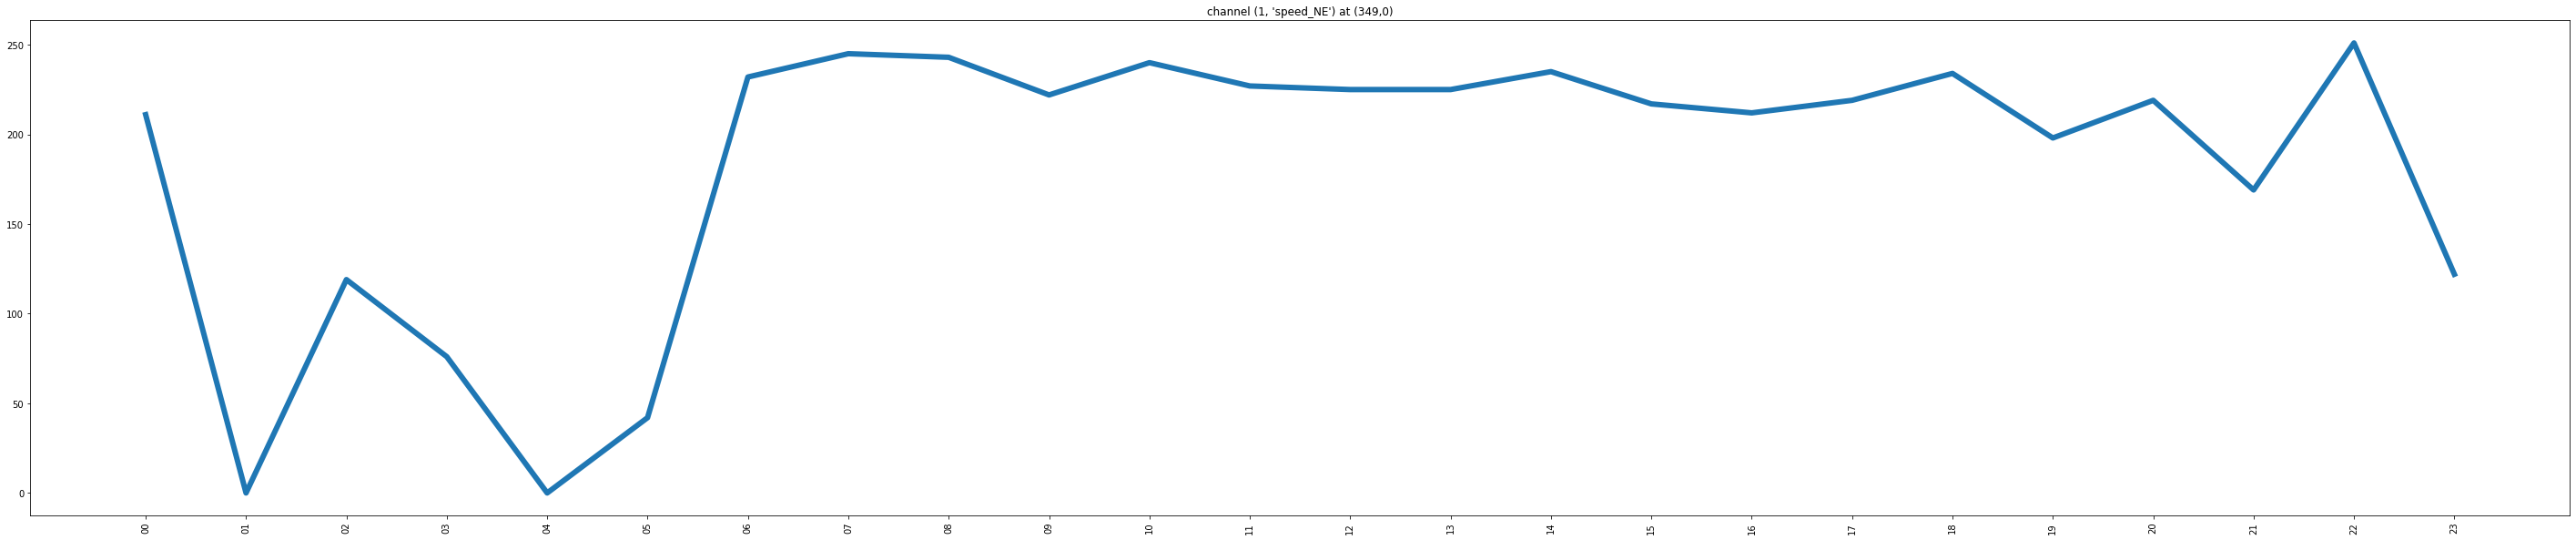

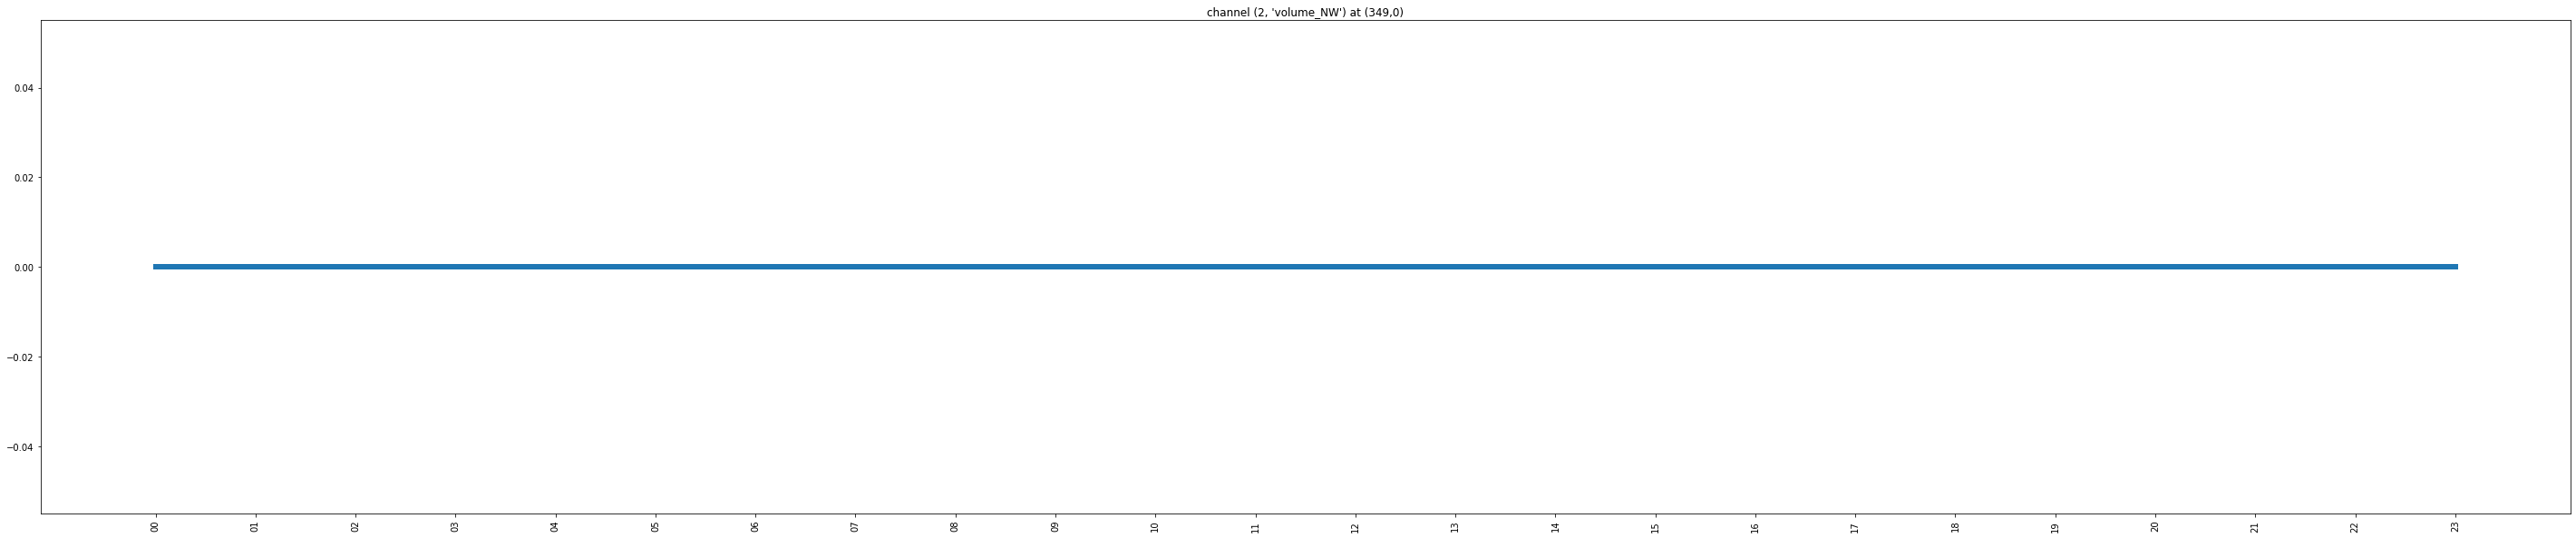

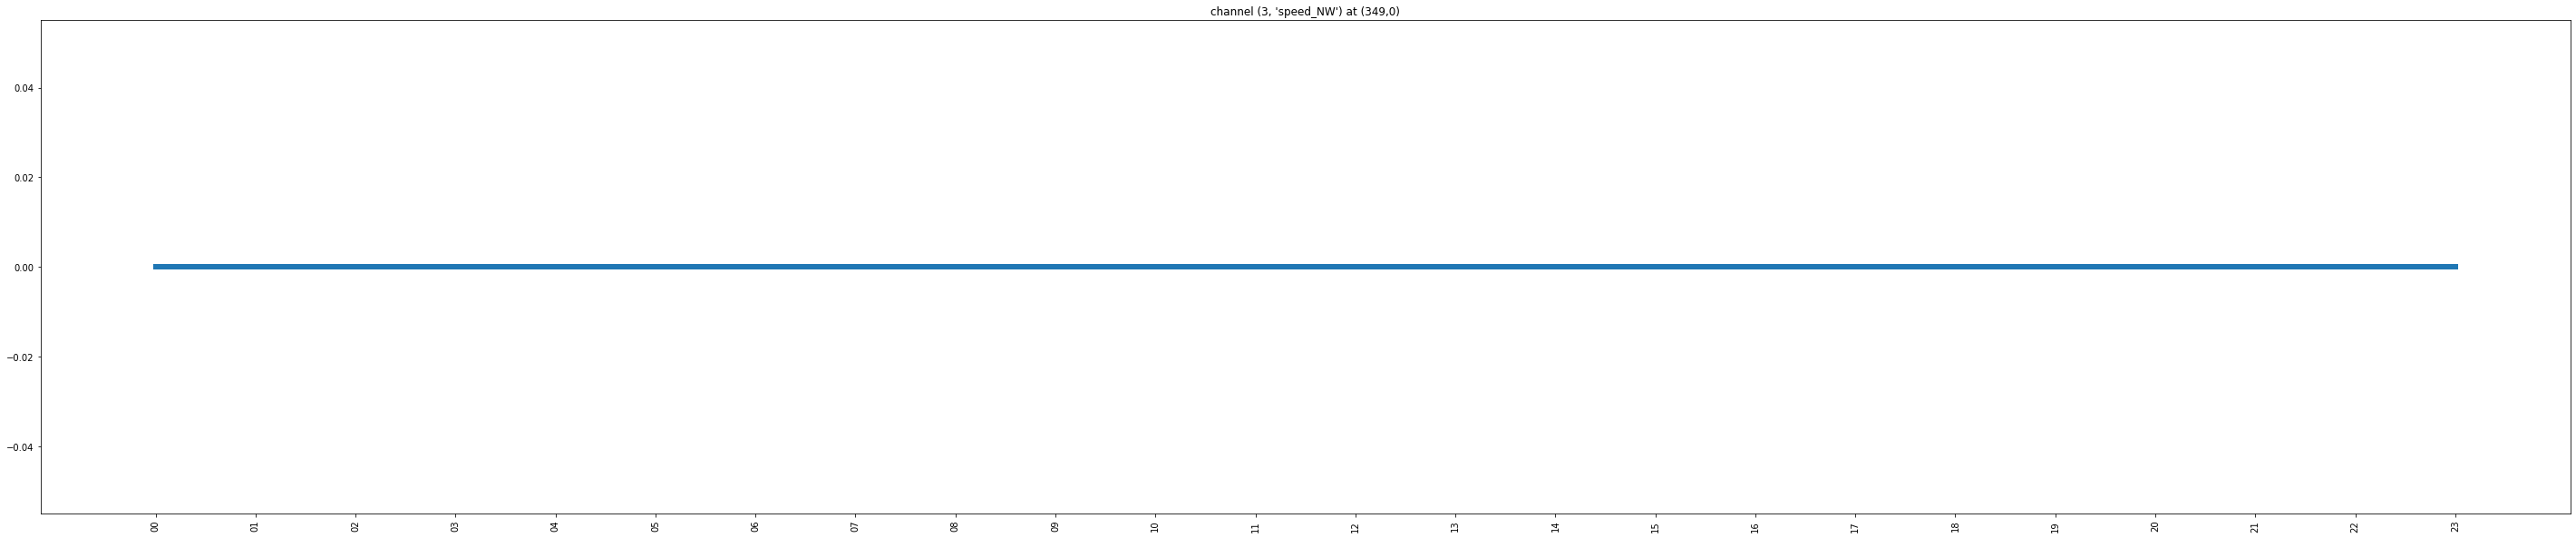

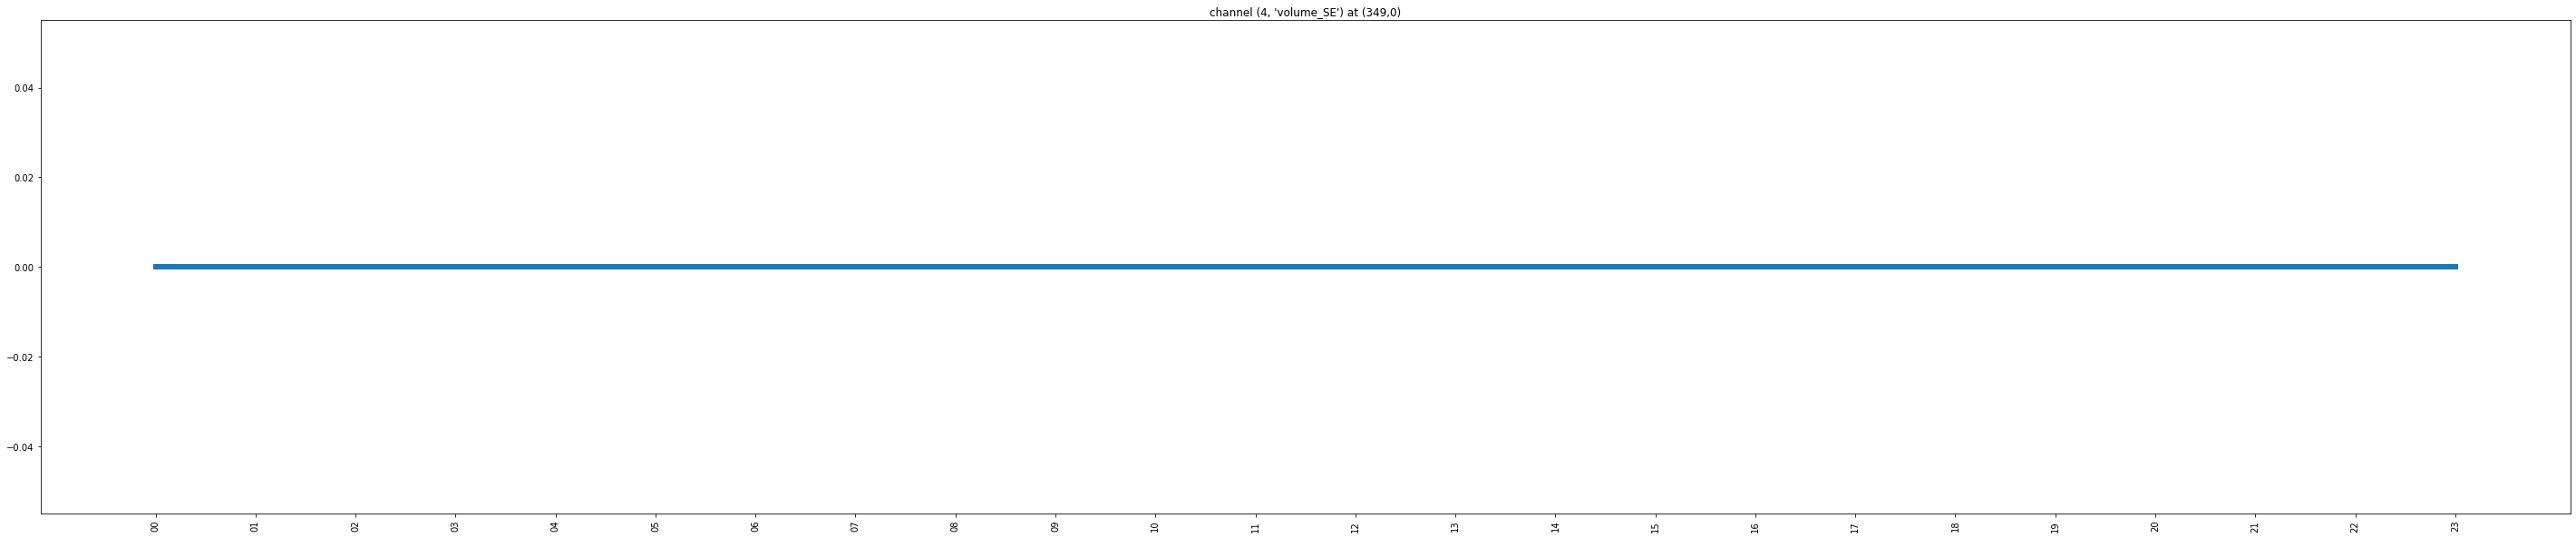

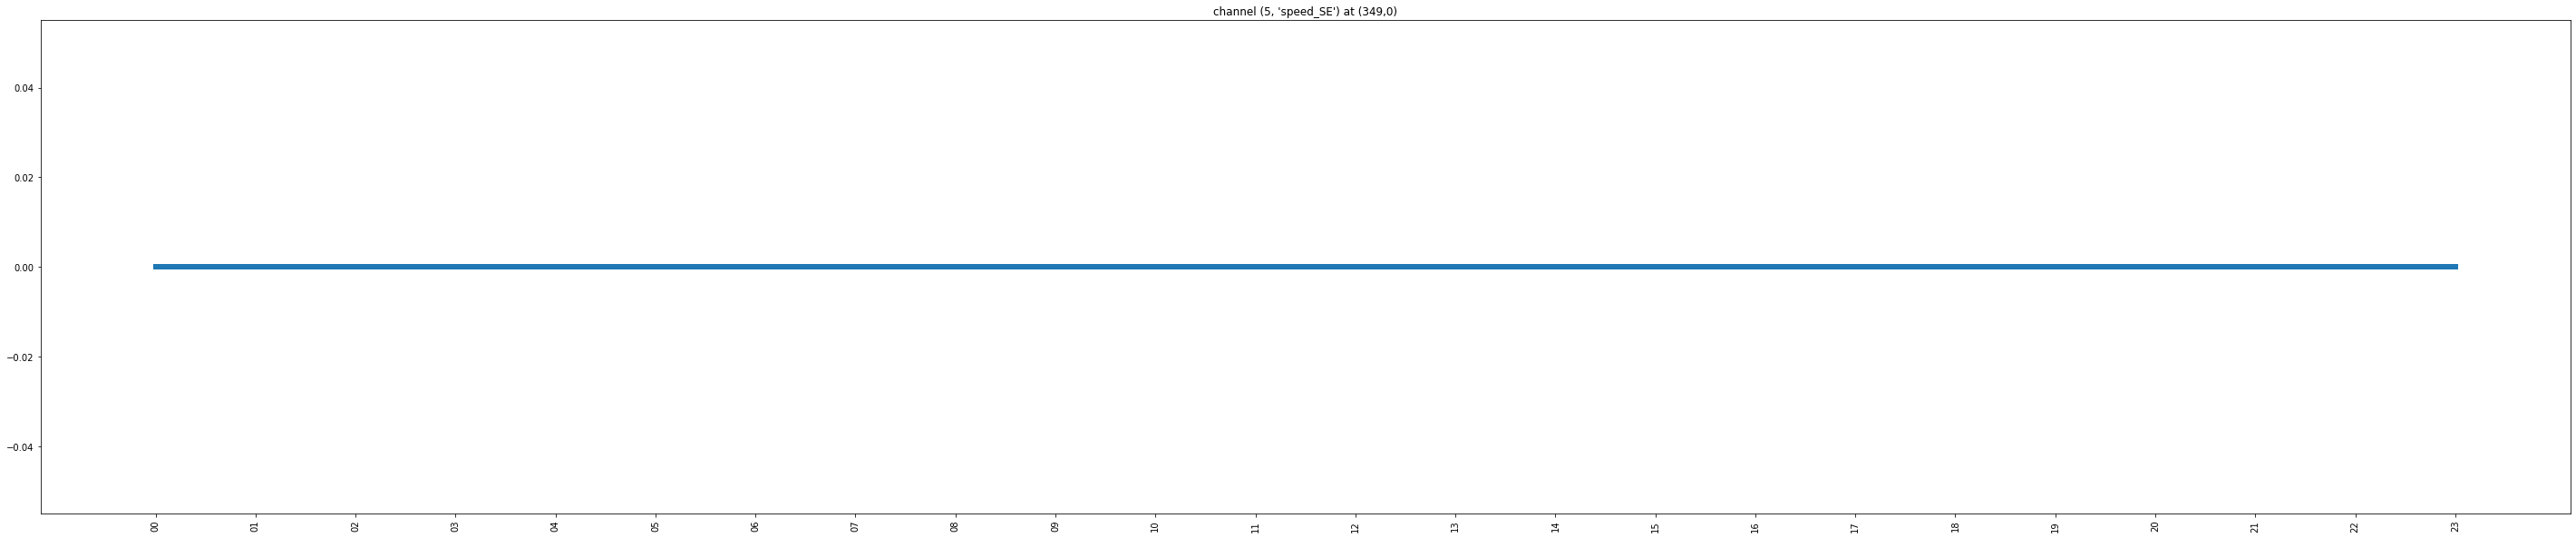

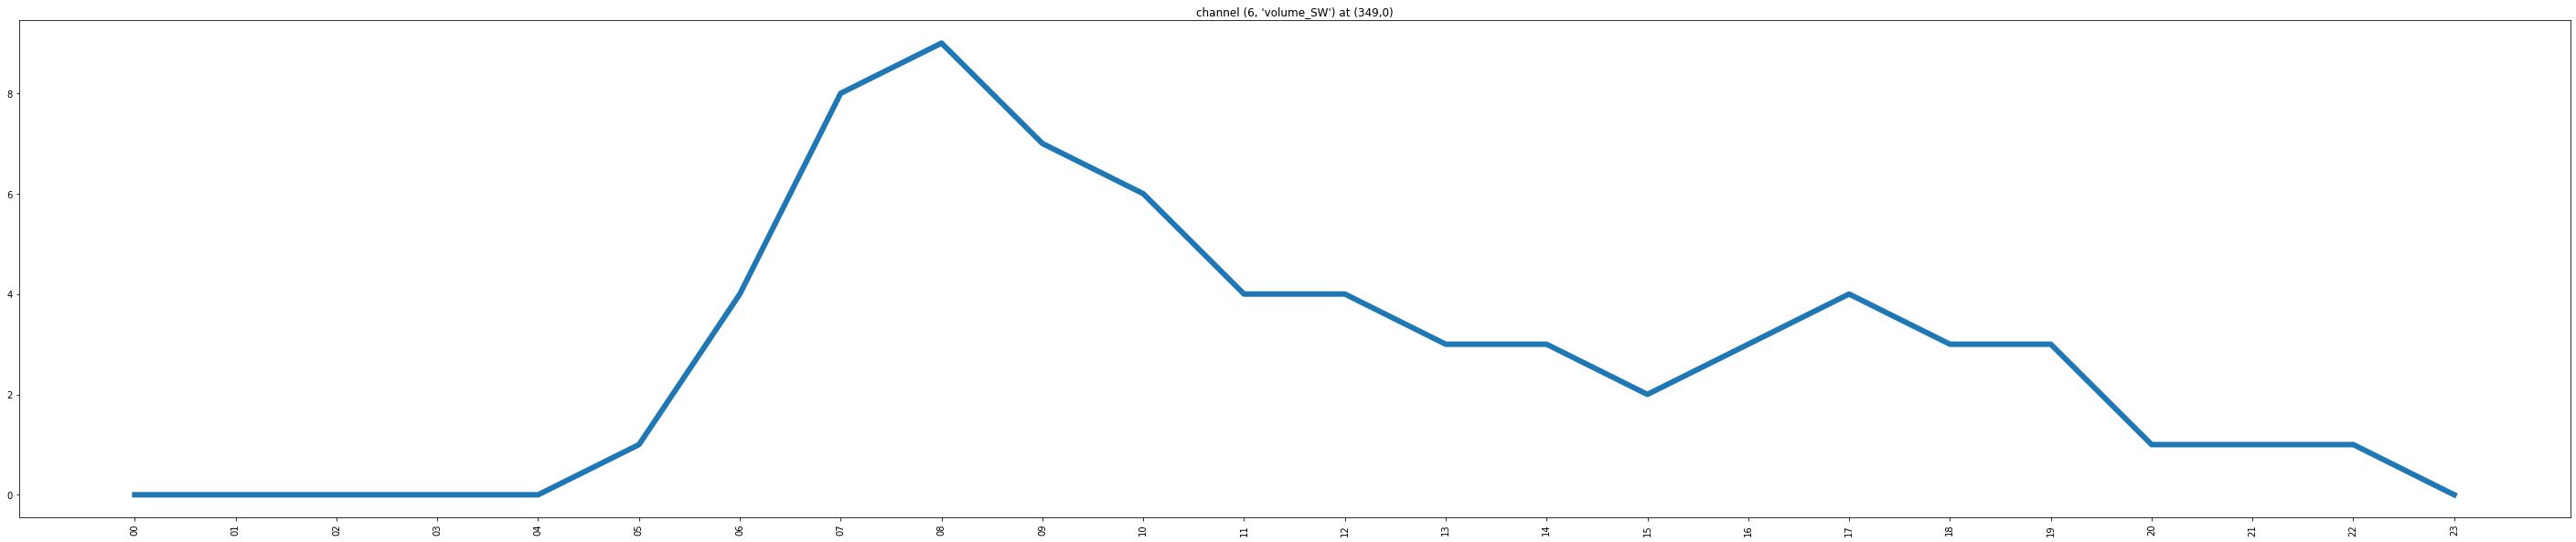

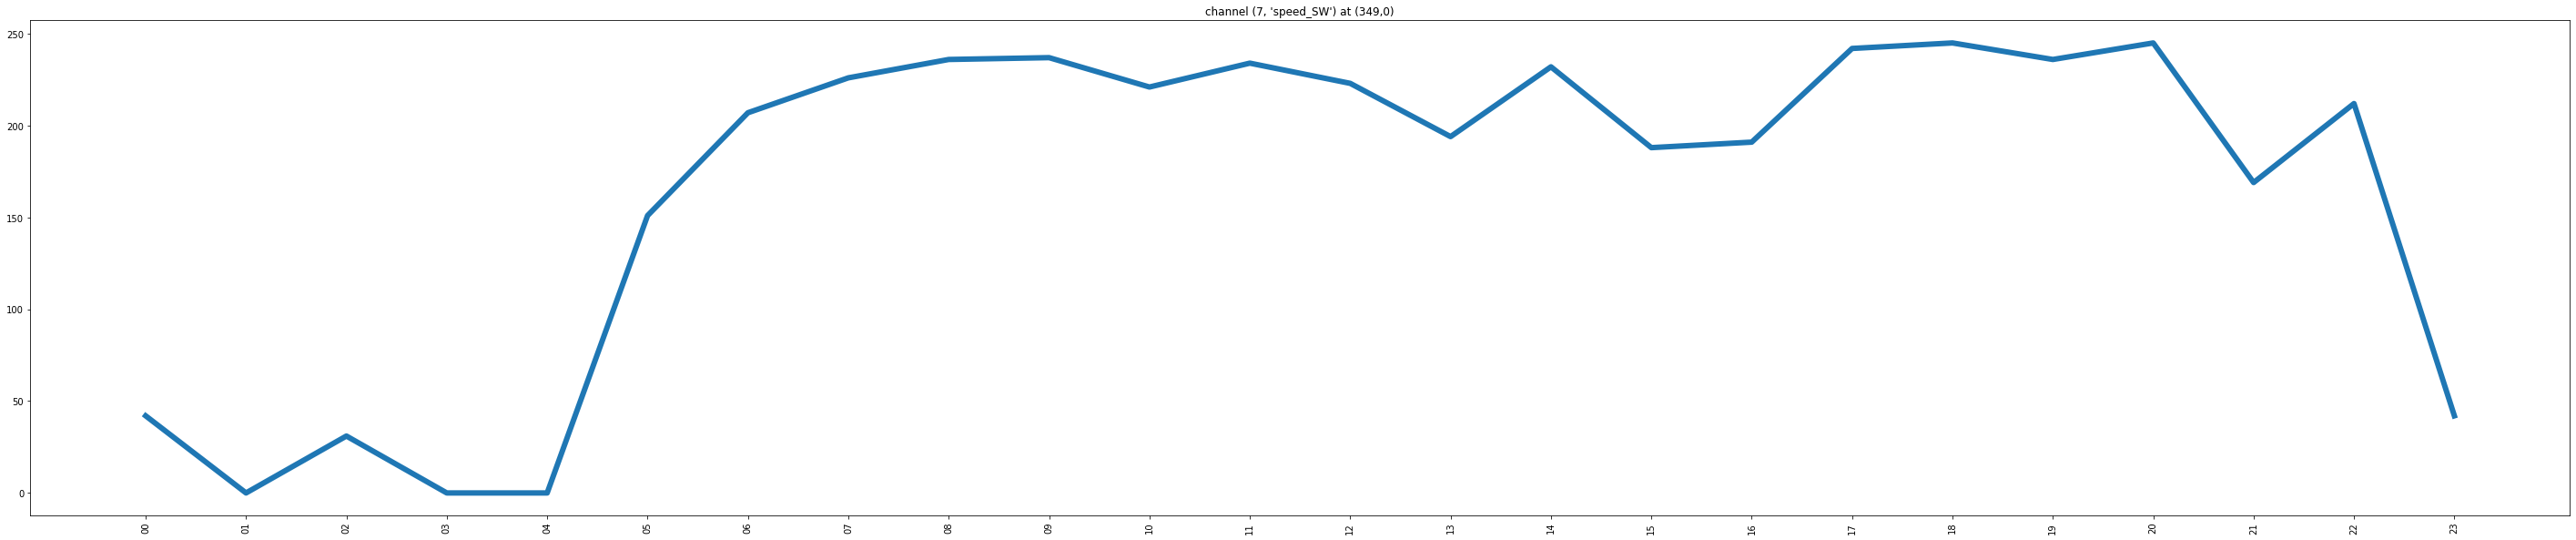

In [10]:
import datetime, os
rows = len(GET_CITIES)
for city in GET_CITIES:
    filename = f"{BASE_FOLDER}/{city}/training/2019-04-03_{city}_8ch_aggregated.h5"
    if os.path.isfile(filename):
        third_apr = load_h5_file(filename)
        print(f"Loaded data has shape {third_apr.shape} with dtype {third_apr.dtype} between {np.min(third_apr)} and {np.max(third_apr)}")

        dailysum = np.sum(third_apr, axis=(0))
        unravelled = np.unravel_index([np.argmax(dailysum[:, :, 1])], (495, 436))
        x = unravelled[0][0]
        y = unravelled[1][0]
        print(f"Reading pixel {x},{y}")

        for ch in range(third_apr.shape[3]):
            plt.figure(figsize=(50, 10))
            plt.title(f"channel {CHANNELS[ch]} at ({x},{y})")
            x_labels = [datetime.time(hour=t).isoformat(timespec="hours") for t in range(24)]
            plt.plot(x_labels, third_apr[:, x, y, ch], linewidth=6)
            plt.xticks(rotation=90)
            plt.show()

In [11]:
import itertools

channel_labels = channel_labels = list(itertools.chain.from_iterable([[f"volume_{h}", f"speed_{h}"] for h in ["NE", "NW", "SE", "SW"]])) + ["incidents"]

pre_covid_range = generate_date_range("2019-04-01", "2019-04-10")
in_covid_range = generate_date_range("2020-04-01", "2020-04-10")
volume_channel_indices = [ch for ch, l in enumerate(channel_labels) if "volume" in l]

print(volume_channel_indices)

[0, 2, 4, 6]


In [12]:
import numpy as np

pre_covid_volumes = {city: np.zeros(shape=(495, 436)) for city in GET_CITIES}
in_covid_volumes = {city: np.zeros(shape=(495, 436)) for city in GET_CITIES}

for city in GET_CITIES:
    for date in pre_covid_range:
        data = load_h5_file(f"{BASE_FOLDER}/{city}/training/{date}_{city}_8ch.h5")
        data = data[:, :, :, volume_channel_indices]
        pre_covid_volumes[city] += np.sum(data, axis=(0, -1))
    for date in in_covid_range:
        in_covid_volumes[city] += np.sum(load_h5_file(f'{BASE_FOLDER}/{city}/training/{date}_{city}_8ch.h5')[:, :, :, volume_channel_indices], axis=(0, -1))

In [13]:
print("pre_covid_range")
for city, volume in pre_covid_volumes.items():
    print(f"{city}: {np.sum(volume)}")
print("in_covid_range")
for city, volume in in_covid_volumes.items():
    print(f"{city}: {np.sum(volume)}")

pre_covid_range
ANTWERP: 41934886.0
in_covid_range
ANTWERP: 23836023.0


In [16]:
print(len(GET_CITIES), 1, scale_factor * 10, len(GET_CITIES) * scale_factor)

1 1 20 2


AttributeError: 'numpy.ndarray' object has no attribute 'barh'

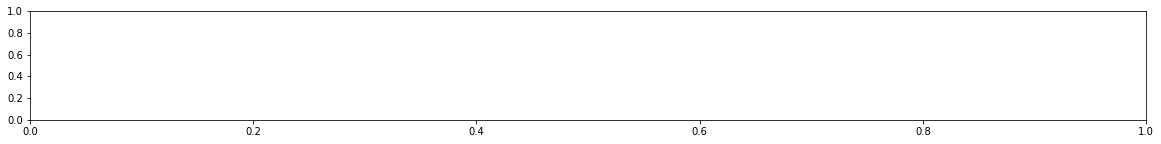

In [19]:
scale_factor = 2
fig, axs = plt.subplots(len(GET_CITIES), 1, figsize=(scale_factor * 10, len(GET_CITIES) * scale_factor),squeeze=False)

for i, city in enumerate(GET_CITIES):
    # axs[i].set_title(f"{city} sum over all volume channels {[channel_labels[ch] for ch in volume_channel_indices]}")
    axs[i].barh(
        [f"{pre_covid_range[0]} - {pre_covid_range[-1]}", f"{in_covid_range[0]} - {in_covid_range[-1]}"],
        [np.sum(pre_covid_volumes[city]), np.sum(in_covid_volumes[city])],)
    axs[i].invert_yaxis()